In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import time
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from lmmnn.nn import reg_nn_ohe_or_ignore, reg_nn_embed, reg_nn_lmm, reg_nn_svdkl, reg_nn_cnn
from lmmnn.simulation import Count

import tensorflow.keras.backend as K

In [3]:
n = 5000
a = 2

A = np.matrix([np.random.randn(n) + np.random.randn(1)*a for i in range(n)])
A = A*np.transpose(A)
D_half = np.diag(np.diag(A)**(-0.5))
G = np.array(D_half*A*D_half)

sig2b = 0.8
sig2e = 1.0
b = np.random.multivariate_normal(np.zeros(n), G * sig2b)
e = np.random.normal(0, np.sqrt(sig2e), n)
y = b + e

y_df = pd.DataFrame({'y': y, 'b_true': b})

In [4]:
print(G.shape)
print(G[:5, :5])

(5000, 5000)
[[ 1.          0.29069927 -0.51854997 -0.0819445   0.53423333]
 [ 0.29069927  1.         -0.49129222 -0.05864254  0.50109418]
 [-0.51854997 -0.49129222  1.          0.11119372 -0.88870655]
 [-0.0819445  -0.05864254  0.11119372  1.         -0.11727911]
 [ 0.53423333  0.50109418 -0.88870655 -0.11727911  1.        ]]


In [5]:
y_df['z0'] = np.arange(y_df.shape[0])
y_df.head()

,y,b_true,z0
0,-0.927102,1.237120,0
1,-1.832850,-0.801229,1
2,-1.615046,-1.046300,2
3,-0.292129,0.537162,3
4,-0.131567,0.868472,4


In [6]:
mode = 'mme'
batch = 100
epochs = 500
patience = 10
qs = []
q_spatial = len(y_df['z0'].unique())
n_neurons = [10]
dropout = []
activation = 'relu'
Z_non_linear = False # will currently only work with g(Z) = Z
Z_embed_dim_pct = 10
n_sig2bs = 0
n_sig2bs_spatial = 1
est_cors = []
time2measure_dict = None
spatial_embed_neurons = None 
# spatial_embed_neurons = [100, 50, 20, 10, 20, 50, 100] # uncomment for LMMNN-E
verbose = False
log_params = False
idx = None
shuffle = False
resolution = 100

In [7]:
def reg_nn(X_train, X_test, y_train, y_test, reg_type, b_true):
    start = time.time()
    if reg_type == 'lmmnn':
        b_hat, sigmas, _, _, n_epochs = reg_nn_lmm(
            X_train, X_test, y_train, y_test, qs, q_spatial, x_cols, batch, epochs, patience,
            n_neurons, dropout, activation, mode,
            n_sig2bs, n_sig2bs_spatial, est_cors, G, spatial_embed_neurons,
            verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx, shuffle, b_true = b_true)
    else:
        raise ValueError(reg_type + 'is an unknown reg_type')
    end = time.time()
    K.clear_session()
    gc.collect()
    mse = np.mean((b_hat - y_df['y'])**2)
    plt.scatter(y_df['y'], b_hat, alpha = 0.5)
    plt.show()
    return mse, sigmas, n_epochs, end - start

iteration 0


C:\Users\gsimchoni\AppData\Roaming\Python\Python38\site-packages\keras\engine\data_adapter.py:1508: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


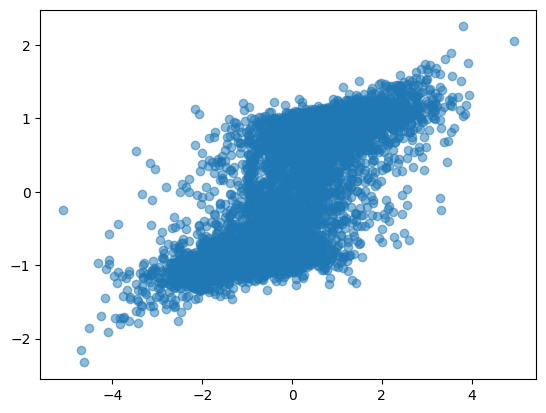

 finished lmmnn, mse: 0.8873
iteration 1


C:\Users\gsimchoni\AppData\Roaming\Python\Python38\site-packages\keras\engine\data_adapter.py:1508: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


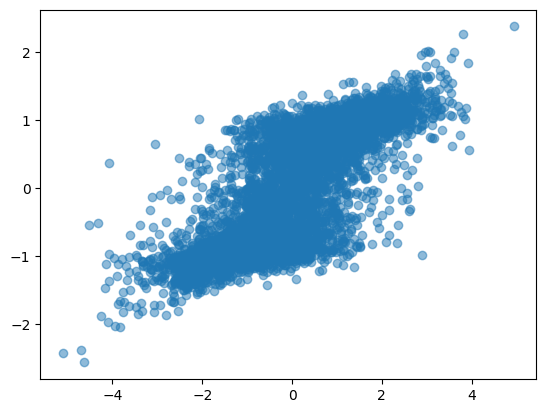

 finished lmmnn, mse: 0.8478
iteration 2


C:\Users\gsimchoni\AppData\Roaming\Python\Python38\site-packages\keras\engine\data_adapter.py:1508: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


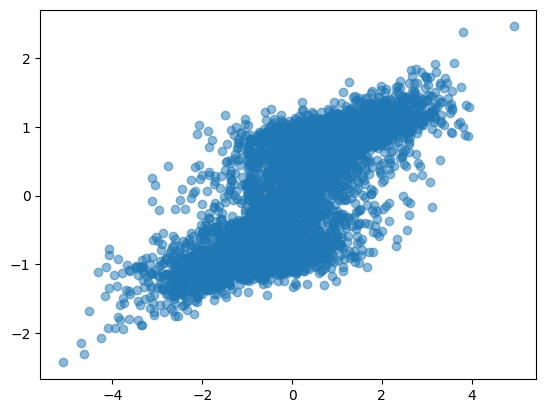

 finished lmmnn, mse: 0.8548
iteration 3


C:\Users\gsimchoni\AppData\Roaming\Python\Python38\site-packages\keras\engine\data_adapter.py:1508: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


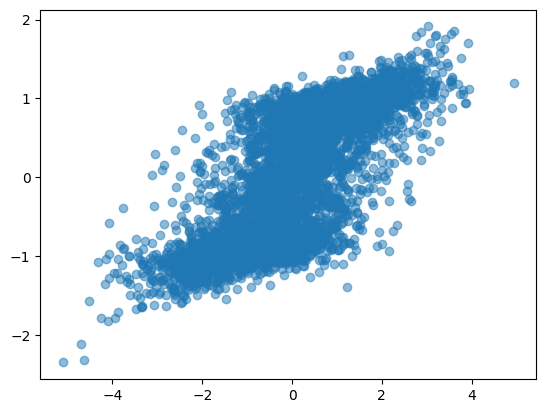

 finished lmmnn, mse: 0.8739
iteration 4


C:\Users\gsimchoni\AppData\Roaming\Python\Python38\site-packages\keras\engine\data_adapter.py:1508: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


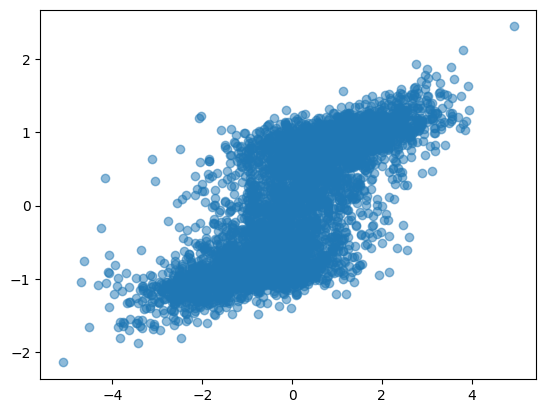

 finished lmmnn, mse: 0.8680


In [8]:
res = pd.DataFrame(columns=['experiment', 'exp_type', 'mse', 'sigma_e_est', 'sigma_b0_est', 'n_epoch', 'time'])
counter = 0

def iterate_reg_types(X_train, X_test, y_train, y_test, b_true):
    mse_lmm, sigmas, n_epochs_lmm, time_lmm = reg_nn(X_train, X_test, y_train, y_test, reg_type='lmmnn', b_true=b_true)
    print(' finished lmmnn, mse: %.4f' % (mse_lmm))
    res.loc[next(counter)] = [i, 'lmmnn', mse_lmm, sigmas[0], sigmas[2][0], n_epochs_lmm, time_lmm]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
counter = Count().gen()
X, y = y_df.drop(['b_true', 'y'], axis=1), y_df['y']
x_cols = [col for col in X.columns if col not in ['z0']]
b_true = y_df['b_true'].values
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    print('iteration %d' % i)
    X_train, X_test, y_train, y_test = X.loc[train_index].copy(), X.loc[test_index].copy(), y[train_index], y[test_index]
    iterate_reg_types(X_train, X_test, y_train, y_test, b_true)

In [9]:
res

,experiment,exp_type,mse,sigma_e_est,sigma_b0_est,n_epoch,time
1,0,lmmnn,0.887266,0.977941,0.812160,74,39.748024
2,1,lmmnn,0.847830,0.956303,0.918171,168,60.800767
3,2,lmmnn,0.854789,0.974636,0.905918,34,24.626842
4,3,lmmnn,0.873865,1.018993,0.846853,221,75.346773
5,4,lmmnn,0.868050,1.013150,0.866528,179,60.247618


In [10]:
# res.to_csv('../../results/res_mme.csv')